In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ranksums, mannwhitneyu
from scipy.stats import ttest_rel
import seaborn as sns

In [3]:
# Load the Excel file
file_path = r'C:\Users\Nikita\results_new.xlsx'  # Using raw string to handle backslashes
data = pd.read_excel(file_path)

# Convert the date column to string
data['date'] = data['date'].astype(str)

# Calculate the differences between home scores and away scores
data['score_difference'] = data['home_score'] - data['away_score']


In [4]:
# Create a connection to the SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('match_results.db')

# Create a cursor object
cur = conn.cursor()

# Drop the table if it exists
cur.execute('DROP TABLE IF EXISTS match_results')

# Create the table with the correct schema
cur.execute('''
CREATE TABLE match_results (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date TEXT,
    home_team TEXT,
    away_team TEXT,
    home_score INTEGER,
    away_score INTEGER,
    tournament TEXT,
    city TEXT,
    country TEXT,
    neutral BOOLEAN,
    score_difference INTEGER
)
''')

# Insert data from the dataframe into the table
for index, row in data.iterrows():
    cur.execute('''
    INSERT INTO match_results (date, home_team, away_team, home_score, away_score, tournament, city, country, neutral, score_difference)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (row['date'], row['home_team'], row['away_team'], row['home_score'], row['away_score'], row['tournament'], row['city'], row['country'], row['neutral'], row['score_difference']))

# Commit the transaction
conn.commit()

# Close the connection
conn.close()




In [5]:
# Re-open the connection to verify data
connection = sqlite3.connect('match_results.db')
cur = connection.cursor()

# Query to ensure data was inserted
cur.execute('SELECT * FROM match_results LIMIT 5')
rows = cur.fetchall()

# Display the first few rows to verify
for row in rows:
    print(row)

# Close the connection
conn.close()


(1, '1933-06-11', 'Sweden', 'Estonia', 6, 2, 'FIFA World Cup qualification', 'Stockholm', 'Sweden', 0, 4)
(2, '1933-06-29', 'Lithuania', 'Sweden', 0, 2, 'FIFA World Cup qualification', 'Kaunas', 'Lithuania', 0, -2)
(3, '1933-09-24', 'Yugoslavia', 'Switzerland', 2, 2, 'FIFA World Cup qualification', 'Belgrade', 'Yugoslavia', 0, 0)
(4, '1933-10-15', 'Poland', 'Czechoslovakia', 1, 2, 'FIFA World Cup qualification', 'Warsaw', 'Poland', 0, -1)
(5, '1933-10-29', 'Switzerland', 'Romania', 2, 2, 'FIFA World Cup qualification', 'Berne', 'Switzerland', 0, 0)


In [6]:
# Calculate the percentages
total_matches = len(data)

home_wins = len(data[data['home_score'] > data['away_score']])
draws = len(data[data['home_score'] == data['away_score']])
away_wins = len(data[data['home_score'] < data['away_score']])

home_wins_percentage = (home_wins / total_matches) * 100
draws_percentage = (draws / total_matches) * 100
away_wins_percentage = (away_wins / total_matches) * 100

# Create a DataFrame for the percentages
percentages_df = pd.DataFrame({
    'Result': ['Home Wins', 'Draws', 'Away Wins'],
    'Percentage': [home_wins_percentage, draws_percentage, away_wins_percentage]
})


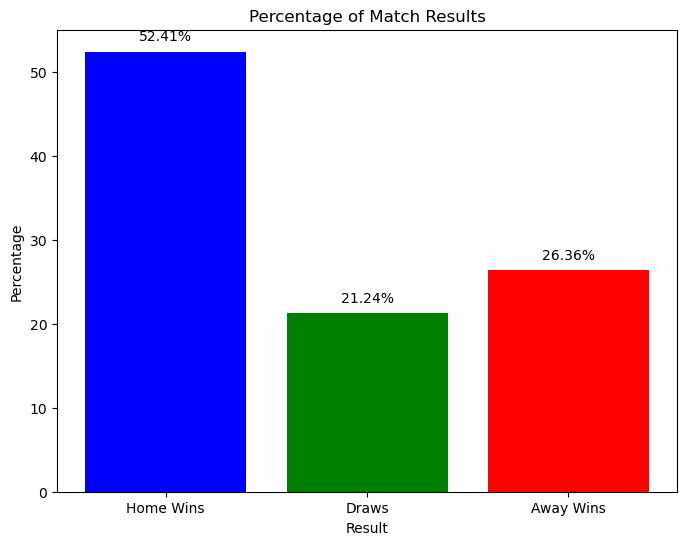

In [7]:
# Plotting the results
fig, ax = plt.subplots(figsize=(8, 6))

# Bar Plot
ax.bar(percentages_df['Result'], percentages_df['Percentage'], color=['blue', 'green', 'red'])
ax.set_title('Percentage of Match Results')
ax.set_xlabel('Result')
ax.set_ylabel('Percentage')

# Adding percentage labels on top of bars
for i in range(len(percentages_df)):
    ax.text(i, percentages_df['Percentage'][i] + 1, f"{percentages_df['Percentage'][i]:.2f}%", ha='center', va='bottom')

# Show plot
plt.show()


T-test results (without zeros):
T-statistic: 13.115545896303516
P-value: 5.487502840956342e-39
Mean of positive differences (without zeros): 2.4344667247893055
Mean of negative differences (without zeros): 1.9754406240970819


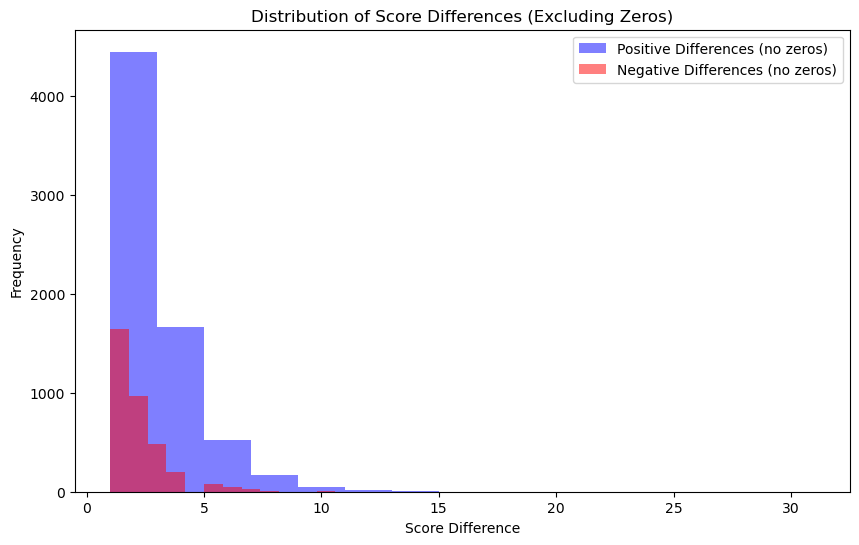

In [8]:
# Separate the positive and negative differences into two series
positive_differences = data['positive difference']
negative_differences = data['negative difference']

# Filter out zero values
positive_differences_no_zero = positive_differences[positive_differences != 0]
negative_differences_no_zero = negative_differences[negative_differences != 0]

# Perform a T-test
t_stat_no_zero, p_value_no_zero = stats.ttest_ind(positive_differences_no_zero.dropna(), negative_differences_no_zero.dropna())

# Calculate means without zeros
mean_positive_no_zero = positive_differences_no_zero.mean()
mean_negative_no_zero = negative_differences_no_zero.mean()

# Print T-test results and means
print(f"T-test results (without zeros):\nT-statistic: {t_stat_no_zero}\nP-value: {p_value_no_zero}")
print(f"Mean of positive differences (without zeros): {mean_positive_no_zero}")
print(f"Mean of negative differences (without zeros): {mean_negative_no_zero}")

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram for positive differences without zeros
ax.hist(positive_differences_no_zero, bins=15, alpha=0.5, label='Positive Differences (no zeros)', color='blue')

# Histogram for negative differences without zeros
ax.hist(negative_differences_no_zero, bins=15, alpha=0.5, label='Negative Differences (no zeros)', color='red')

# Adding titles and labels
ax.set_title('Distribution of Score Differences (Excluding Zeros)')
ax.set_xlabel('Score Difference')
ax.set_ylabel('Frequency')
ax.legend()

# Show plot
plt.show()


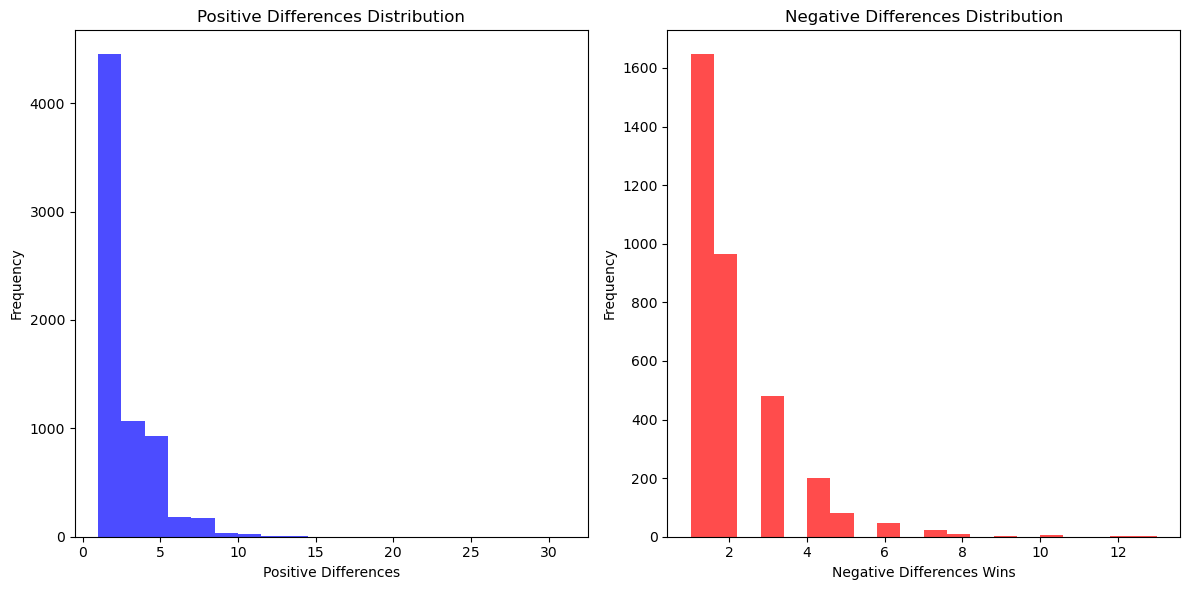

Positive Differences Normality Test: ShapiroResult(statistic=0.7416278719902039, pvalue=0.0)
Negative Differences Normality Test: ShapiroResult(statistic=0.7342570424079895, pvalue=0.0)


C:\Users\Nikita\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
# Heare we cheked if 'home win' and 'away win' colums have normal distributions
# Extract home and away scores
positive_differences = data['positive difference']
negative_differences = data['negative difference']

# Filter out zero values
positive_differences_no_zero = positive_differences[positive_differences != 0]
negative_differences_no_zero = negative_differences[negative_differences != 0]

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(positive_differences_no_zero, bins=20, color='blue', alpha=0.7)
plt.title('Positive Differences Distribution')
plt.xlabel('Positive Differences')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(negative_differences_no_zero, bins=20, color='red', alpha=0.7)
plt.title('Negative Differences Distribution')
plt.xlabel('Negative Differences Wins')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Perform normality tests using Shapiro-Wilk test
positive_differences_normality = stats.shapiro(positive_differences_no_zero)
negative_differences_normality = stats.shapiro(negative_differences_no_zero)

print("Positive Differences Normality Test:", positive_differences_normality)
print("Negative Differences Normality Test:", negative_differences_normality)


C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mann-Whitney U Test results:
Statistic: 13558987.0
P-value: 1.0625274284150907e-33


C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


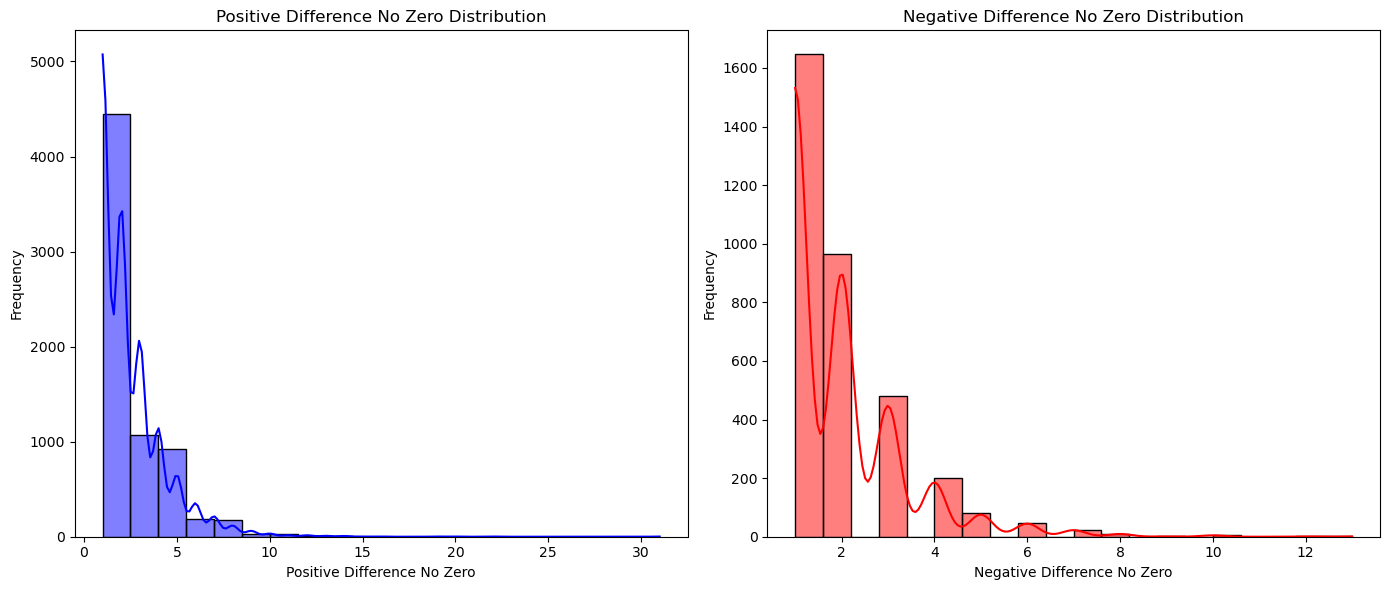

C:\Users\Nikita\AppData\Local\Temp\ipykernel_10900\4125904896.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(positive_differences_no_zero, shade=True, color="blue", label="Positive Difference No Zero")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10900\4125904896.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(negative_differences_no_zero, shade=True, color="red", label="Negative Difference No Zero")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: 

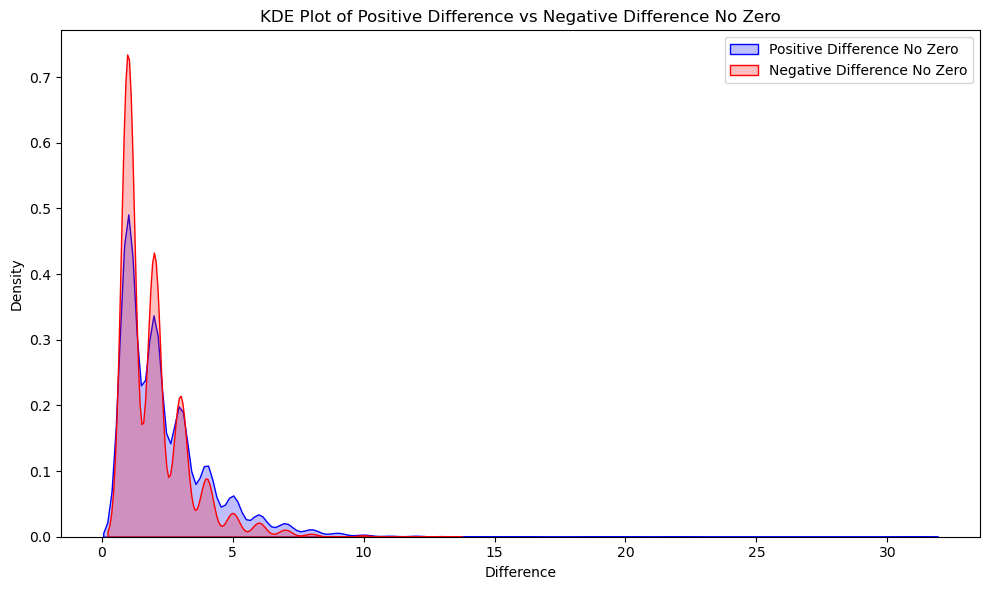

In [10]:
# Assuming 'positive difference' and 'negative difference' are the columns you want to compare
positive_differences = data['positive difference']
negative_differences = data['negative difference']

# Filter out zero values
positive_differences_no_zero = positive_differences[positive_differences != 0]
negative_differences_no_zero = negative_differences[negative_differences != 0]

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(positive_differences_no_zero, negative_differences_no_zero)

# Print results
print(f"Mann-Whitney U Test results:\nStatistic: {stat}\nP-value: {p_value}")

# Plotting histograms
plt.figure(figsize=(14, 6))

# Histogram for Positive Difference
plt.subplot(1, 2, 1)
sns.histplot(positive_differences_no_zero, kde=True, color='blue', bins=20)
plt.title('Positive Difference No Zero Distribution')
plt.xlabel('Positive Difference No Zero')
plt.ylabel('Frequency')

# Histogram for Negative Difference
plt.subplot(1, 2, 2)
sns.histplot(negative_differences_no_zero, kde=True, color='red', bins=20)
plt.title('Negative Difference No Zero Distribution')
plt.xlabel('Negative Difference No Zero')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plotting Kernel Density Estimate (KDE) plots
plt.figure(figsize=(10, 6))

sns.kdeplot(positive_differences_no_zero, shade=True, color="blue", label="Positive Difference No Zero")
sns.kdeplot(negative_differences_no_zero, shade=True, color="red", label="Negative Difference No Zero")

plt.title('KDE Plot of Positive Difference vs Negative Difference No Zero')
plt.xlabel('Difference')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Length of home wins: 13132
Length of away wins: 13132
Paired T-test results (including zeros):
T-statistic: 35.18676015188838
P-value: 2.8415433210904043e-259
Mean of home wins (including zeros): 0.5240633566859579
Mean of away wins (including zeros): 0.2635546756015839


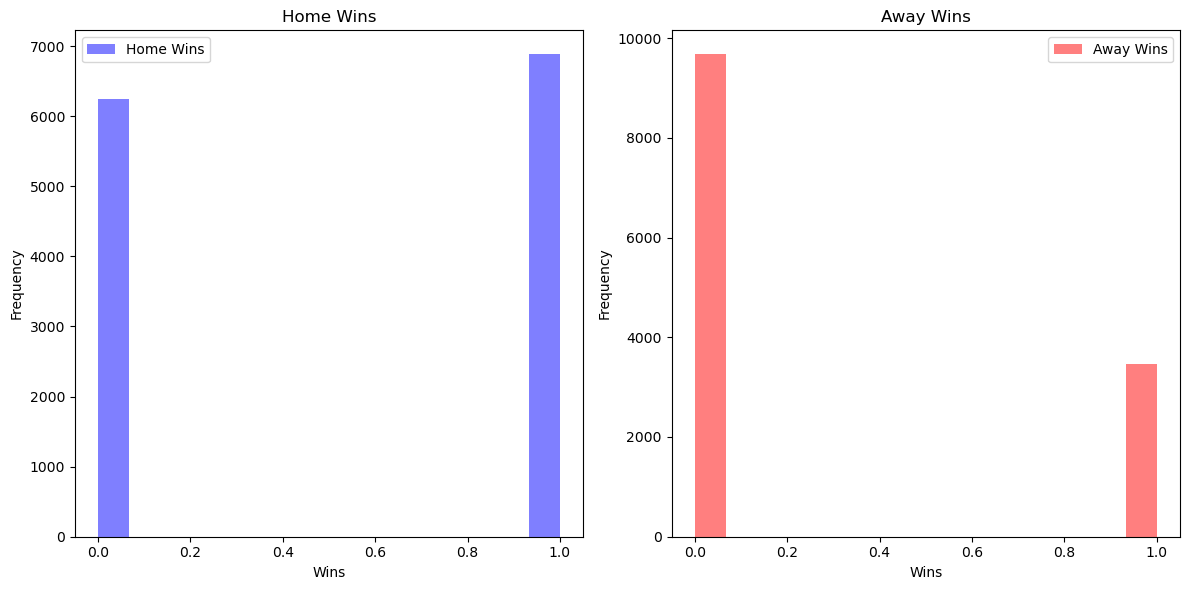

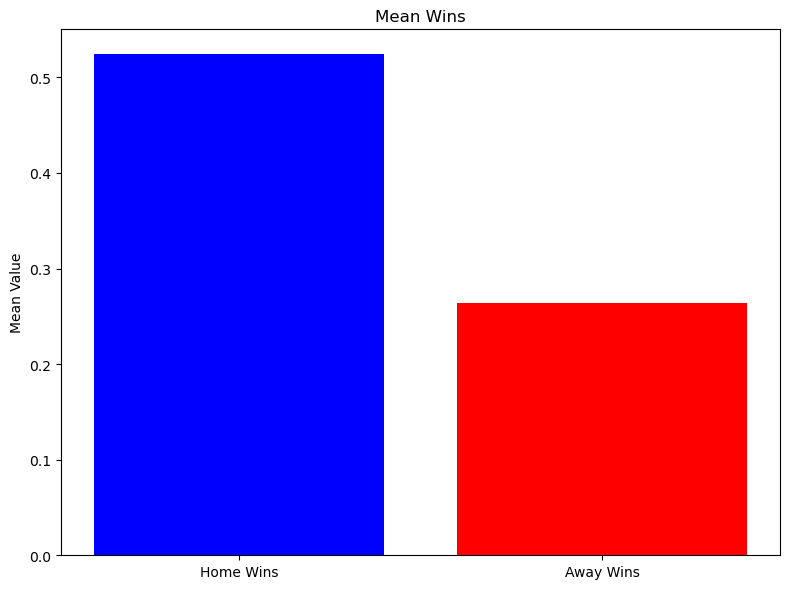

In [11]:
# Replace NaNs with zeros in 'home win' and 'away win' columns
data['home win'].fillna(0, inplace=True)
data['away win'].fillna(0, inplace=True)

# Extract home and away scores
home_win = data['home win']
away_win = data['away win']

# Check the lengths of the series
print(f"Length of home wins: {len(home_win)}")
print(f"Length of away wins: {len(away_win)}")

# Perform paired T-test
t_stat_no_zero, p_value_no_zero = ttest_rel(home_win, away_win)

# Calculate means including zeros
mean_home_win = home_win.mean()
mean_away_win = away_win.mean()

# Print paired T-test results and means
print(f"Paired T-test results (including zeros):\nT-statistic: {t_stat_no_zero}\nP-value: {p_value_no_zero}")
print(f"Mean of home wins (including zeros): {mean_home_win}")
print(f"Mean of away wins (including zeros): {mean_away_win}")

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for home wins
ax[0].hist(home_win, bins=15, alpha=0.5, label='Home Wins', color='blue')
ax[0].set_title('Home Wins')
ax[0].set_xlabel('Wins')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Histogram for away wins
ax[1].hist(away_win, bins=15, alpha=0.5, label='Away Wins', color='red')
ax[1].set_title('Away Wins')
ax[1].set_xlabel('Wins')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.savefig('paired_ttest_histograms_wins.png')
plt.show()

# Bar chart for means
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Home Wins', 'Away Wins']
means = [mean_home_win, mean_away_win]

ax.bar(categories, means, color=['blue', 'red'])
ax.set_title('Mean Wins')
ax.set_ylabel('Mean Value')

plt.tight_layout()
plt.savefig('mean_wins_comparison.png')
plt.show()

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'difference',
       'positive difference', 'negative difference', 'difference in absoulute',
       'Unnamed: 13', 'Unnamed: 14', 'sort of numbers', 'positive wilcoson',
       'negative wilcoson', 'home win', 'away win', 'competition',
       'score_difference'],
      dtype='object')
Wilcoxon rank-sum test results:
Statistic: -0.7273547397024835
P-value: 0.4670086730023424
Mean of positive rankings (without zeros): 5475.12726032071
Mean of negative rankings (without zeros): 5539.648610323313


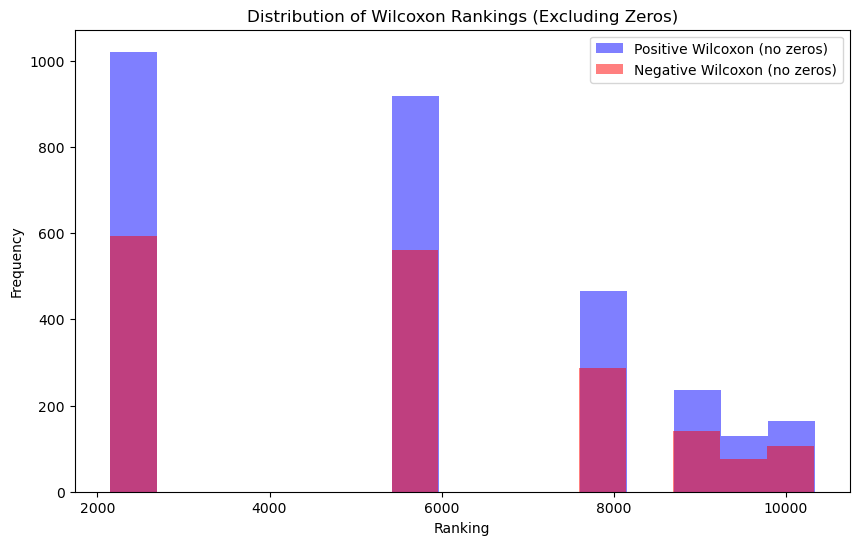

In [12]:
# Inspect the columns to ensure correct column names
print(data.columns)

# Use the correct column names based on the inspection
rankings_positive = data['positive wilcoson']
rankings_negative = data['negative wilcoson']

# Filter out zero values if needed
rankings_positive_no_zero = rankings_positive[rankings_positive != 0]
rankings_negative_no_zero = rankings_negative[rankings_negative != 0]

# Perform Wilcoxon rank-sum test
stat, p_value = ranksums(rankings_positive_no_zero.dropna(), rankings_negative_no_zero.dropna())

# Calculate means
mean_positive = rankings_positive_no_zero.mean()
mean_negative = rankings_negative_no_zero.mean()

# Print Wilcoxon test results and means
print(f"Wilcoxon rank-sum test results:\nStatistic: {stat}\nP-value: {p_value}")
print(f"Mean of positive rankings (without zeros): {mean_positive}")
print(f"Mean of negative rankings (without zeros): {mean_negative}")

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram for positive rankings without zeros
ax.hist(rankings_positive_no_zero, bins=15, alpha=0.5, label='Positive Wilcoxon (no zeros)', color='blue')

# Histogram for negative rankings without zeros
ax.hist(rankings_negative_no_zero, bins=15, alpha=0.5, label='Negative Wilcoxon (no zeros)', color='red')

# Adding titles and labels
ax.set_title('Distribution of Wilcoxon Rankings (Excluding Zeros)')
ax.set_xlabel('Ranking')
ax.set_ylabel('Frequency')
ax.legend()

# Show plot
plt.show()

Paired T-test results (without zeros):
T-statistic: 17.096445376496348
P-value: 7.54612906842305e-64
Mean of positive differences (without zeros): 2.06856716974101
Mean of negative differences (without zeros): 1.6515744363704117


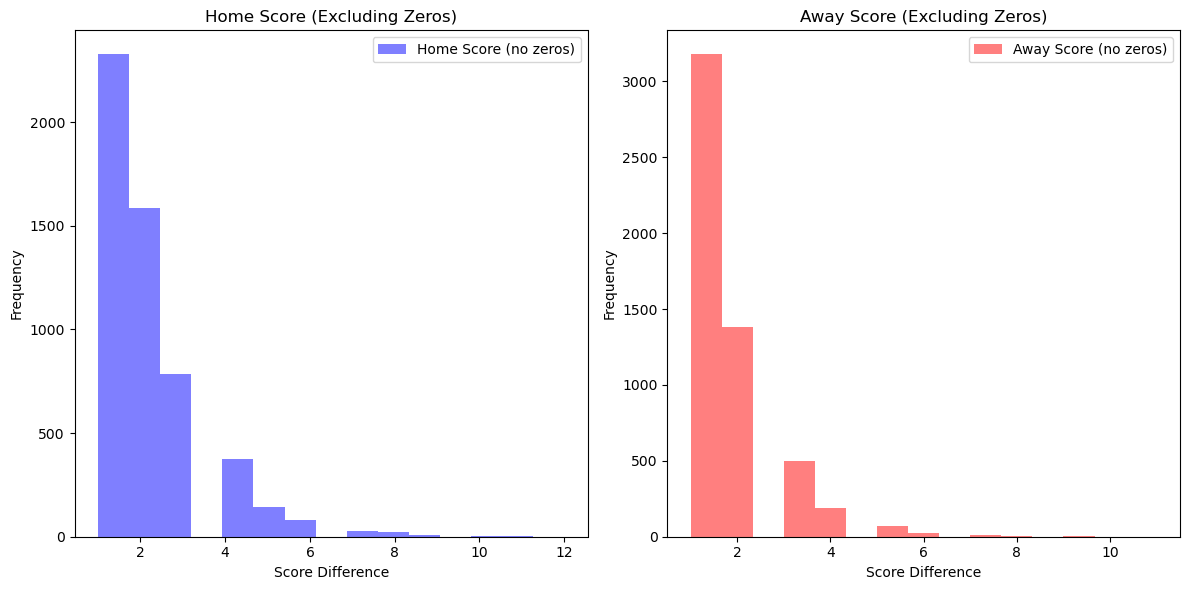

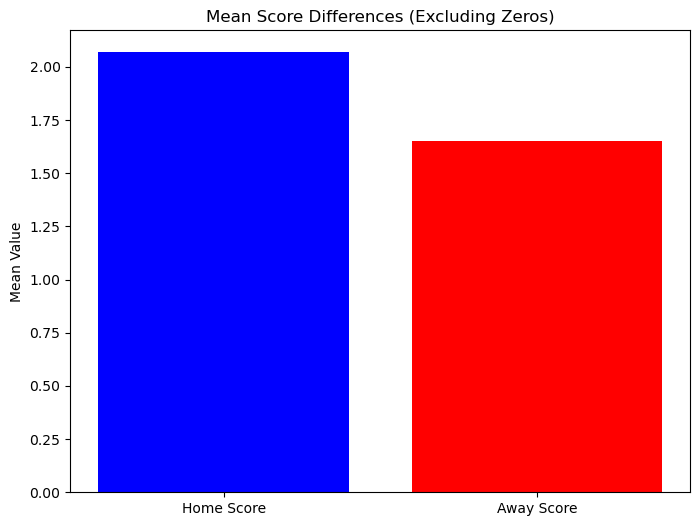

In [13]:
# Separate the positive and negative differences into two series
home_score = data['home_score']
away_scor = data['away_score']

# Align the data to ensure pairs are maintained and filter out zero values
aligned_data = pd.DataFrame({'positive': home_score, 'negative': away_scor})
aligned_data = aligned_data[(aligned_data['positive'] != 0) & (aligned_data['negative'] != 0)]

# Perform paired T-test
t_stat_no_zero, p_value_no_zero = ttest_rel(aligned_data['positive'], aligned_data['negative'])

# Calculate means without zeros
mean_positive_no_zero = aligned_data['positive'].mean()
mean_negative_no_zero = aligned_data['negative'].mean()

# Print paired T-test results and means
print(f"Paired T-test results (without zeros):\nT-statistic: {t_stat_no_zero}\nP-value: {p_value_no_zero}")
print(f"Mean of positive differences (without zeros): {mean_positive_no_zero}")
print(f"Mean of negative differences (without zeros): {mean_negative_no_zero}")

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for positive differences without zeros
ax[0].hist(aligned_data['positive'], bins=15, alpha=0.5, label='Home Score (no zeros)', color='blue')
ax[0].set_title('Home Score (Excluding Zeros)')
ax[0].set_xlabel('Score Difference')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Histogram for negative differences without zeros
ax[1].hist(aligned_data['negative'], bins=15, alpha=0.5, label='Away Score (no zeros)', color='red')
ax[1].set_title('Away Score (Excluding Zeros)')
ax[1].set_xlabel('Score Difference')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.savefig('paired_ttest_histograms.png')
plt.show()

# Bar chart for means
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Home Score', 'Away Score']
means = [mean_positive_no_zero, mean_negative_no_zero]

ax.bar(categories, means, color=['blue', 'red'])
ax.set_title('Mean Score Differences (Excluding Zeros)')
ax.set_ylabel('Mean Value')

plt.savefig('mean_score_differences_comparison.png')
plt.show()


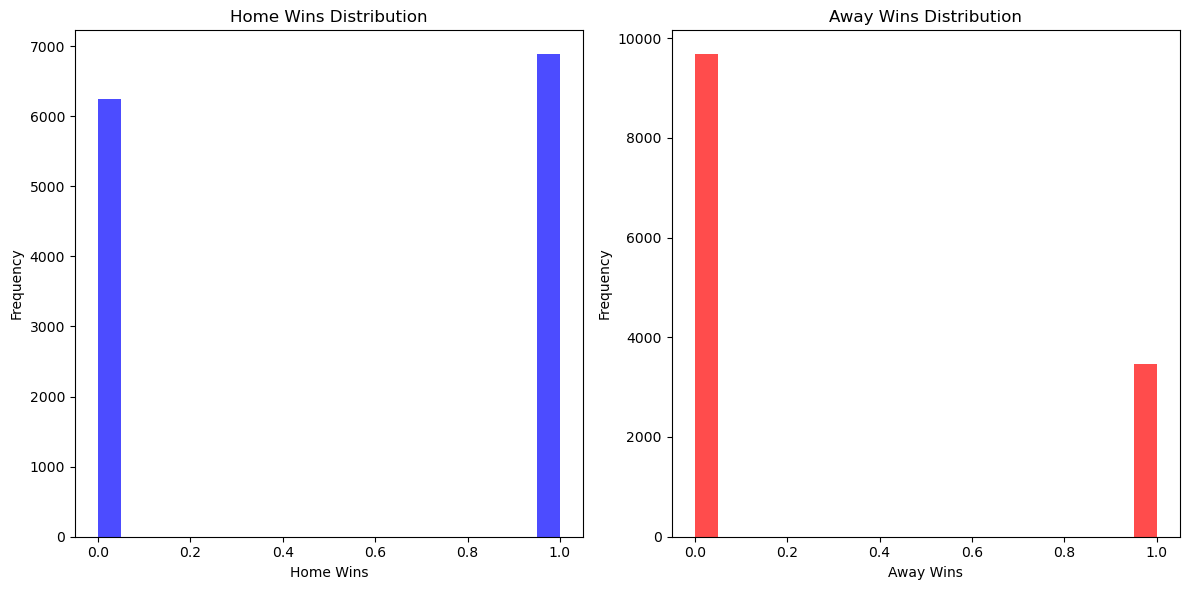

Home Win Normality Test: ShapiroResult(statistic=0.6357088685035706, pvalue=0.0)
Away Win Normality Test: ShapiroResult(statistic=0.5497009754180908, pvalue=0.0)


C:\Users\Nikita\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [14]:
# Heare we cheked if 'home win' and 'away win' colums have normal distributions
# Extract home and away scores
home_win = data['home win']
away_win = data['away win']

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(home_win, bins=20, color='blue', alpha=0.7)
plt.title('Home Wins Distribution')
plt.xlabel('Home Wins')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(away_win, bins=20, color='red', alpha=0.7)
plt.title('Away Wins Distribution')
plt.xlabel('Away Wins')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Perform normality tests using Shapiro-Wilk test
home_win_normality = stats.shapiro(home_win)
away_win_normality = stats.shapiro(away_win)

print("Home Win Normality Test:", home_win_normality)
print("Away Win Normality Test:", away_win_normality)


Mann-Whitney U Test results:
Statistic: 108686998.0
P-value: 0.0


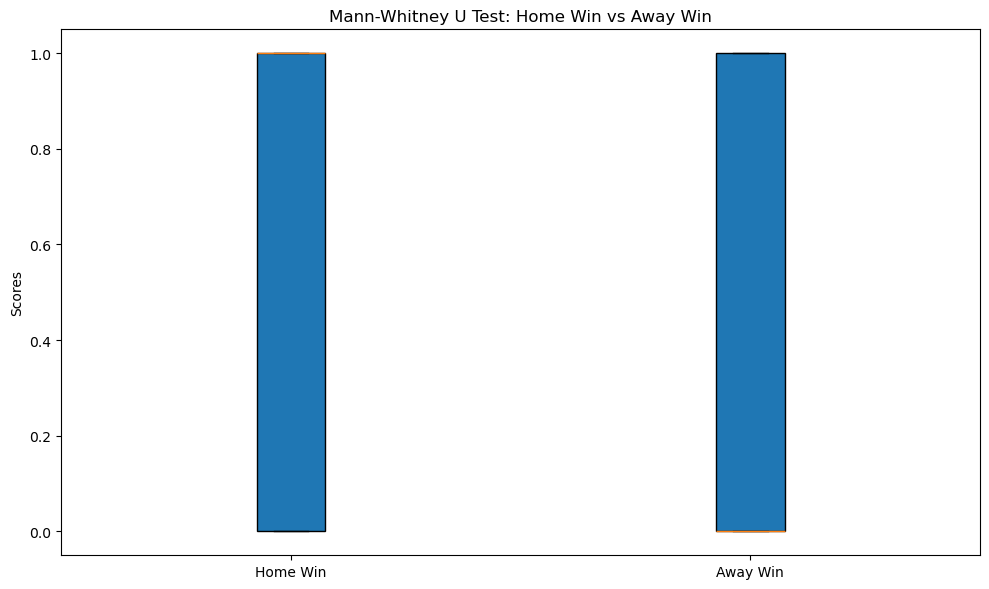

In [15]:
# Assuming 'home win' and 'away win' are the columns you want to compare
home_win = data['home win']
away_win = data['away win']

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(home_win, away_win)

# Print results
print(f"Mann-Whitney U Test results:\nStatistic: {stat}\nP-value: {p_value}")

# Plotting the results
plt.figure(figsize=(10, 6))

# Box plot for home win and away win
plt.boxplot([home_win, away_win], labels=['Home Win', 'Away Win'], patch_artist=True)

# Title and labels
plt.title('Mann-Whitney U Test: Home Win vs Away Win')
plt.ylabel('Scores')

# Show plot
plt.tight_layout()
plt.show()

C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


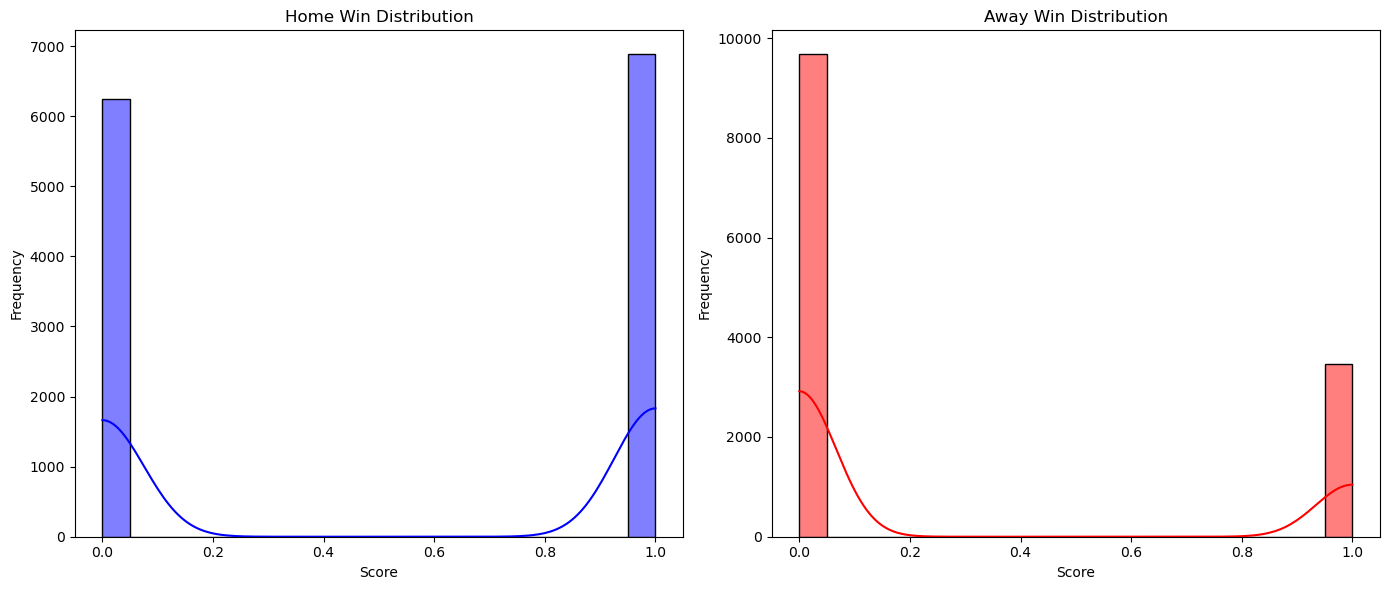

C:\Users\Nikita\AppData\Local\Temp\ipykernel_10900\3321310234.py:34: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(home_win, shade=True, color="blue", label="Home Win")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\AppData\Local\Temp\ipykernel_10900\3321310234.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(away_win, shade=True, color="red", label="Away Win")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fut

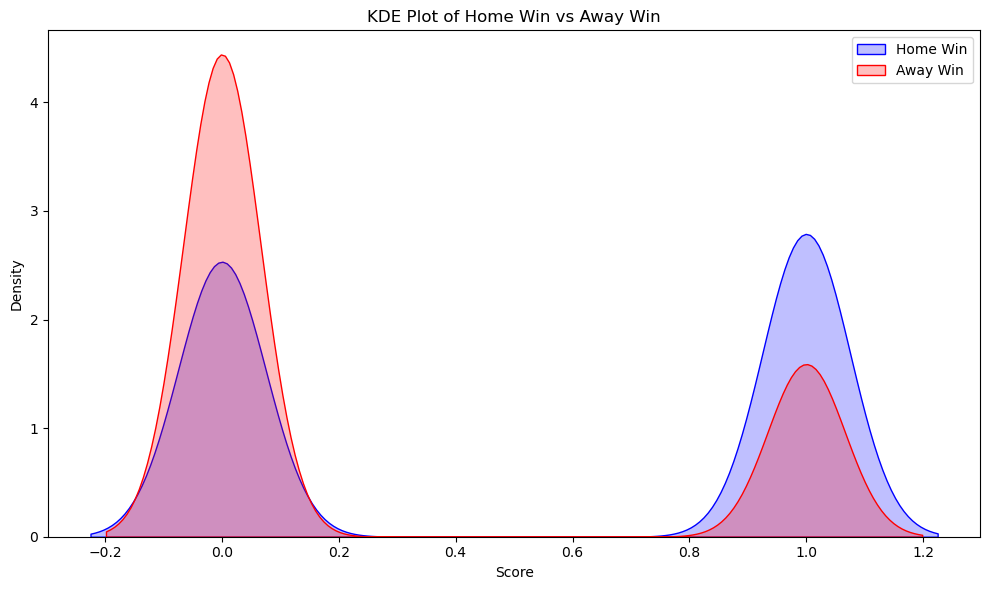

In [16]:
# Assuming 'home win' and 'away win' are the columns you want to compare
home_win = data['home win']
away_win = data['away win']

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'Home Win': home_win,
    'Away Win': away_win
})

# Plotting histograms
plt.figure(figsize=(14, 6))

# Histogram for Home Win
plt.subplot(1, 2, 1)
sns.histplot(home_win, kde=True, color='blue', bins=20)
plt.title('Home Win Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

# Histogram for Away Win
plt.subplot(1, 2, 2)
sns.histplot(away_win, kde=True, color='red', bins=20)
plt.title('Away Win Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plotting Kernel Density Estimate (KDE) plots
plt.figure(figsize=(10, 6))

sns.kdeplot(home_win, shade=True, color="blue", label="Home Win")
sns.kdeplot(away_win, shade=True, color="red", label="Away Win")

plt.title('KDE Plot of Home Win vs Away Win')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
from scipy.stats import kruskal


# Assuming 'region' represents different regions/countries and 'outcome' is the outcome variable
# Modify these column names based on your actual dataset
competition = data['competition']  # Column representing different regions or groups
outcome = data['home win']  # Column with outcomes (e.g., recovery time)

# Prepare the data for Kruskal-Wallis test
competition_data = [outcome[competition == region] for region in competition.unique()]

# Perform the Kruskal-Wallis test
stat, p_value = kruskal(*competition_data)

# Print the results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p_value}")


Kruskal-Wallis Test Statistic: 44.22984635508561
P-value: 2.993028854939029e-06


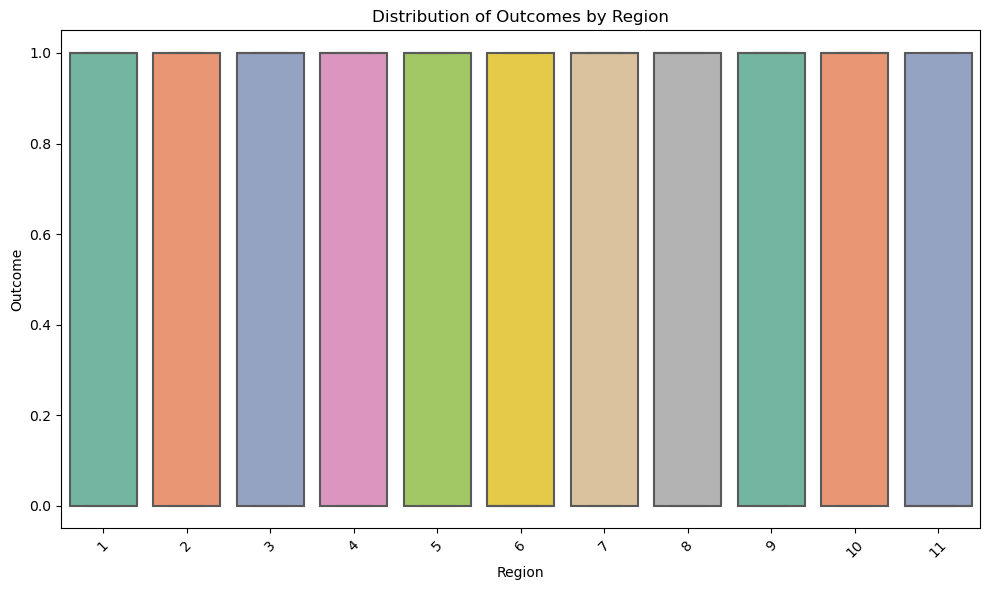

In [18]:
# Plot the distributions of outcomes by group
plt.figure(figsize=(10, 6))
sns.boxplot(x=competition, y=outcome, palette="Set2")
plt.title('Distribution of Outcomes by Region')
plt.xlabel('Region')
plt.ylabel('Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
!pip install scikit-posthocs

          1    2         3         4         5    6    7         8    9    10  \
1   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  0.469084  1.0  1.0   
2   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
3   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
4   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
5   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  0.041966  1.0  1.0   
6   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
7   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
8   0.469084  1.0  1.000000  1.000000  0.041966  1.0  1.0  1.000000  1.0  1.0   
9   1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
10  1.000000  1.0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  1.0  1.0   
11  0.009136  1.0  0.980178  0.498374  0.000034  1.0  1.0  0.318192  1.0  1.0   

          11  
1   0.009136

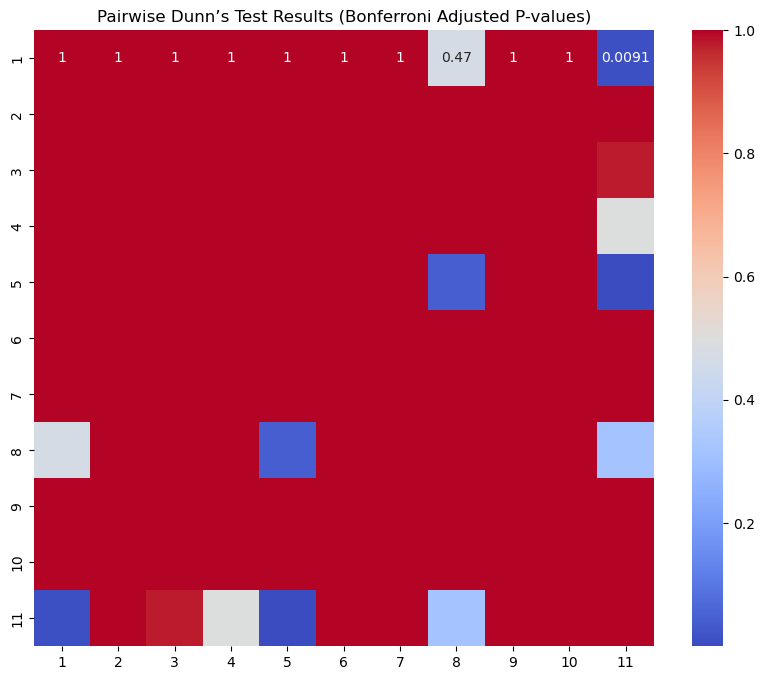

In [20]:
import pandas as pd
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal


# If significant, perform post-hoc Dunn's test
if p_value < 0.05:
    # Melt the data for the test
    df_melted = pd.melt(data, id_vars=['competition'], value_vars=['home win'])

    # Perform Dunn's post-hoc test
    posthoc = sp.posthoc_dunn(df_melted, val_col='value', group_col='competition', p_adjust='bonferroni')

    # Display the pairwise p-values
    print(posthoc)

    # Optional: Visualize the results
    plt.figure(figsize=(10, 8))
    sns.heatmap(posthoc, annot=True, cmap='coolwarm', cbar=True)
    plt.title('Pairwise Dunn’s Test Results (Bonferroni Adjusted P-values)')
    plt.show()
else:
    print("No significant difference found in Kruskal-Wallis test, so no post-hoc analysis is necessary.")


C:\Users\Nikita\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Home First Goal Normality Test: ShapiroResult(statistic=0.6229138970375061, pvalue=0.0)
Away First Goal Normality Test: ShapiroResult(statistic=0.6230895519256592, pvalue=0.0)
Wilcoxon Signed-Rank Test Statistic: 61591068.0
P-value: 1.4974167158565043e-117
Reject H₀: There is a significant difference, the home team has a higher chance of scoring the first goal.


C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


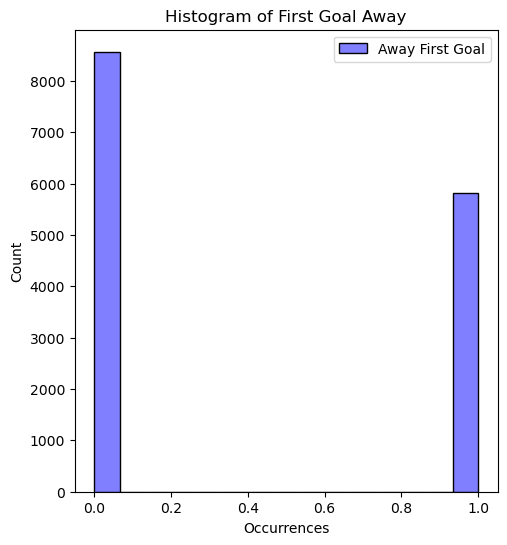

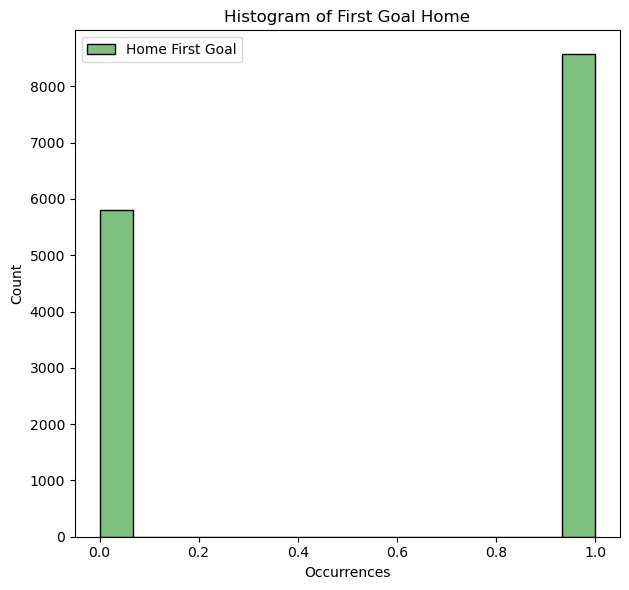

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, shapiro

# Load your data (CSV format)
file_path = r'C:\\Users\\Nikita\\STproject\\goalscorersN.csv'  # Correct file path
data_goals = pd.read_csv(file_path)

# Filter rows where 'first goal' equals 1
filtered_data = data_goals[data_goals['first goal'] == 1]

# Assuming 'first goal home' and 'first goal away' are the columns to compare
home_first_goal = filtered_data['first goal home']  # Column for home team chances of scoring the first goal
away_first_goal = filtered_data['first goal away']  # Column for away team chances of scoring the first goal

# Check if the columns have non-normal distributions using the Shapiro-Wilk test
distribution_home = shapiro(home_first_goal)
distribution_away = shapiro(away_first_goal)

print(f"Home First Goal Normality Test: {distribution_home}")
print(f"Away First Goal Normality Test: {distribution_away}")

# Perform the Wilcoxon Signed-Rank Test for one-sided alternative (home team has higher chance)
stat, p_value = wilcoxon(home_first_goal, away_first_goal, alternative='greater')

# Print the Wilcoxon test results
print(f"Wilcoxon Signed-Rank Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject H₀: There is a significant difference, the home team has a higher chance of scoring the first goal.")
else:
    print("Fail to reject H₀: There is no significant difference, or the away team has an equal or higher chance.")

# Plot the distributions
plt.figure(figsize=(12, 6))

# Histogram for visualizing the frequency distribution
plt.subplot(1, 2, 2)
sns.histplot(away_first_goal, color='blue', label='Away First Goal', alpha=0.5, multiple='dodge')
plt.title('Histogram of First Goal Away')
plt.xlabel('Occurrences')
plt.legend()

# Plot the distributions
plt.figure(figsize=(12, 6))

# Histogram for visualizing the frequency distribution
plt.subplot(1, 2, 2)
sns.histplot(home_first_goal, color='green', label='Home First Goal', alpha=0.5, multiple='dodge')
plt.title('Histogram of First Goal Home')
plt.xlabel('Occurrences')
plt.legend()

plt.tight_layout()
plt.show()

Kruskal-Wallis Test Statistic: 18.80015589364347
P-value: 0.0003006820346392265
Performing Dunn's post-hoc test...
              1933-1964  1965-1984  1985-2004  2005-present
1933-1964        1.0000   1.000000   1.000000      0.914100
1965-1984        1.0000   1.000000   0.164428      0.000256
1985-2004        1.0000   0.164428   1.000000      0.097504
2005-present     0.9141   0.000256   0.097504      1.000000


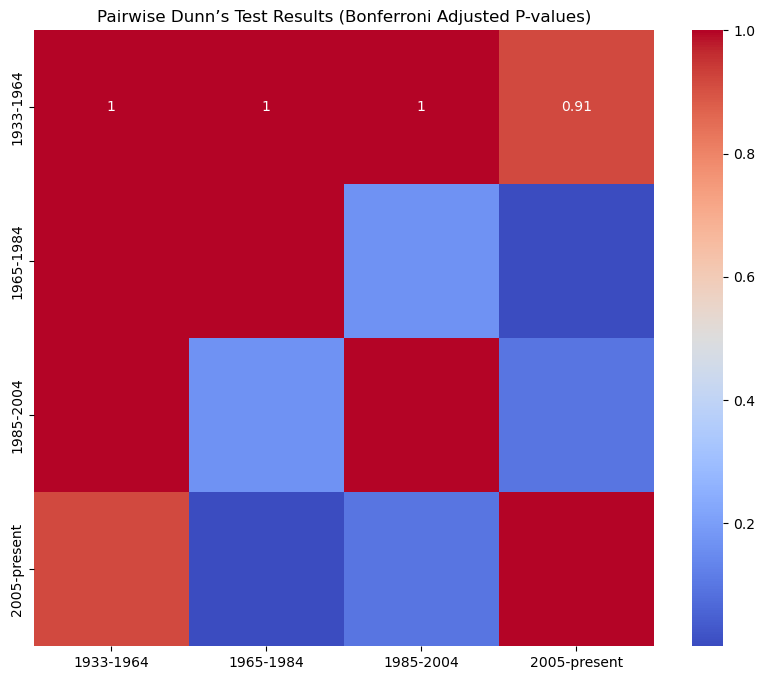

In [25]:
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns


# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Filter the data for the different time periods
period1 = data[(data['date'] >= '1933-06-11') & (data['date'] <= '1964-12-31')].copy()
period2 = data[(data['date'] >= '1965-01-01') & (data['date'] <= '1984-12-31')].copy()
period3 = data[(data['date'] >= '1985-01-01') & (data['date'] <= '2004-12-31')].copy()
period4 = data[(data['date'] >= '2005-01-01') & (data['date'] <= pd.Timestamp.now())].copy()

# Label each period
period1['period'] = '1933-1964'
period2['period'] = '1965-1984'
period3['period'] = '1985-2004'
period4['period'] = '2005-present'

# Combine the data for all periods
combined_data = pd.concat([period1, period2, period3, period4])

# Assuming you have an outcome column to compare, e.g., 'home win'
outcome_column = 'home win'  # Modify this as per your dataset

# Perform the Kruskal-Wallis test to compare the periods
stat, p_value = kruskal(period1[outcome_column], period2[outcome_column], period3[outcome_column], period4[outcome_column])

# Print the Kruskal-Wallis test results
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Perform Dunn's post-hoc test if Kruskal-Wallis test is significant
if p_value < 0.05:
    print("Performing Dunn's post-hoc test...")

    # Perform Dunn's post-hoc test
    posthoc = sp.posthoc_dunn(combined_data, val_col=outcome_column, group_col='period', p_adjust='bonferroni')

    # Display the pairwise p-values
    print(posthoc)

    # Visualization of Dunn's test results
    plt.figure(figsize=(10, 8))
    sns.heatmap(posthoc, annot=True, cmap='coolwarm', cbar=True)
    plt.title('Pairwise Dunn’s Test Results (Bonferroni Adjusted P-values)')
    plt.show()
else:
    print("No significant differences found in the Kruskal-Wallis test.")


In [38]:
# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Filter the data for the two periods
period2 = data[(data['date'] >= '1933-06-11') & (data['date'] <= '1984-12-31')].copy()
period4 = data[(data['date'] >= '2005-01-01') & (data['date'] <= pd.Timestamp.now())]

# Assuming you have some outcome variable to compare, e.g., 'home win'
outcome_column = 'home win'  # Modify this as per your dataset

# Extract the outcome data for each period
outcome_period2 = period2[outcome_column]
outcome_period4 = period4[outcome_column]

# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(outcome_period2, outcome_period4, alternative='two-sided')

# Print the results
print(f"Mann-Whitney U Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two periods (1965-1984 vs. 2005-present).")
else:
    print("No significant difference found between the two periods.")

Mann-Whitney U Test Statistic: 2917489.0
P-value: 0.0009371740628265472
There is a significant difference between the two periods (1965-1984 vs. 2005-present).


In [44]:
import pandas as pd
from scipy.stats import mannwhitneyu


# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Filter the data for the two periods
period2 = data[(data['date'] >= '1965-01-01') & (data['date'] <= '1984-12-31')]
period4 = data[(data['date'] >= '2005-01-01') & (data['date'] <= pd.Timestamp.now())]

# Assuming you have some outcome variable to compare, e.g., 'home win'
outcome_column = 'home win'  # Modify this as per your dataset

# Extract the outcome data for each period
outcome_period2 = period2[outcome_column]
outcome_period4 = period4[outcome_column]

# Perform the Mann-Whitney U test for a one-sided alternative hypothesis
# Change 'greater' or 'less' depending on your hypothesis
stat, p_value = mannwhitneyu(outcome_period2, outcome_period4, alternative='greater')

# Print the results
print(f"Mann-Whitney U Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference, and the 1965-1984 period tends to have larger values.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference, or the 2005-present period has larger values.")


Mann-Whitney U Test Statistic: 3949588.0
P-value: 0.0004131149572736323
Reject the null hypothesis: There is a significant difference, and the 1965-1984 period tends to have larger values.


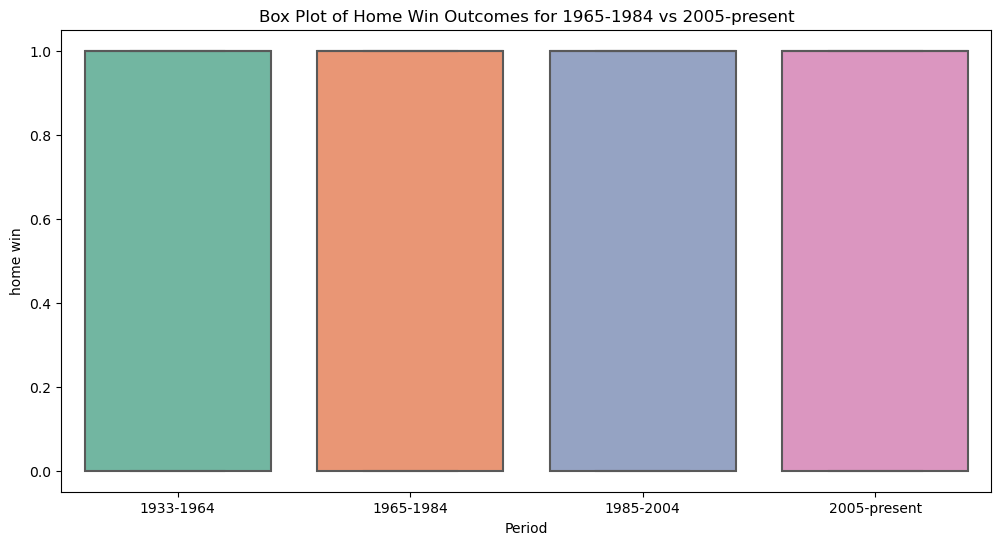

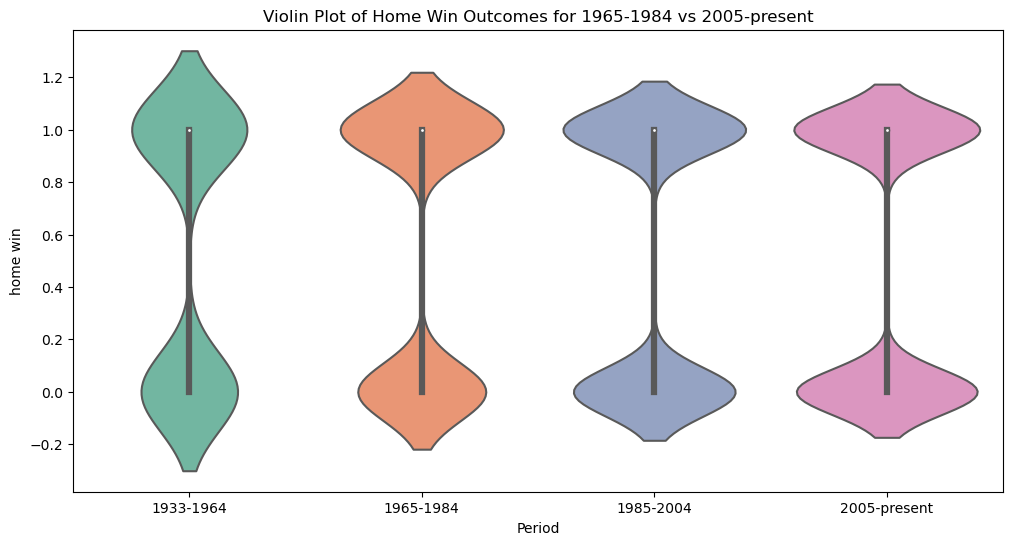

In [47]:
# Create Box Plot to compare the distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='period', y=outcome_column, data=combined_data, palette="Set2")
plt.title('Box Plot of Home Win Outcomes for 1965-1984 vs 2005-present')
plt.xlabel('Period')
plt.ylabel(outcome_column)
plt.show()

# Create Violin Plot for a more detailed distribution comparison
plt.figure(figsize=(12, 6))
sns.violinplot(x='period', y=outcome_column, data=combined_data, palette="Set2")
plt.title('Violin Plot of Home Win Outcomes for 1965-1984 vs 2005-present')
plt.xlabel('Period')
plt.ylabel(outcome_column)
plt.show()

C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


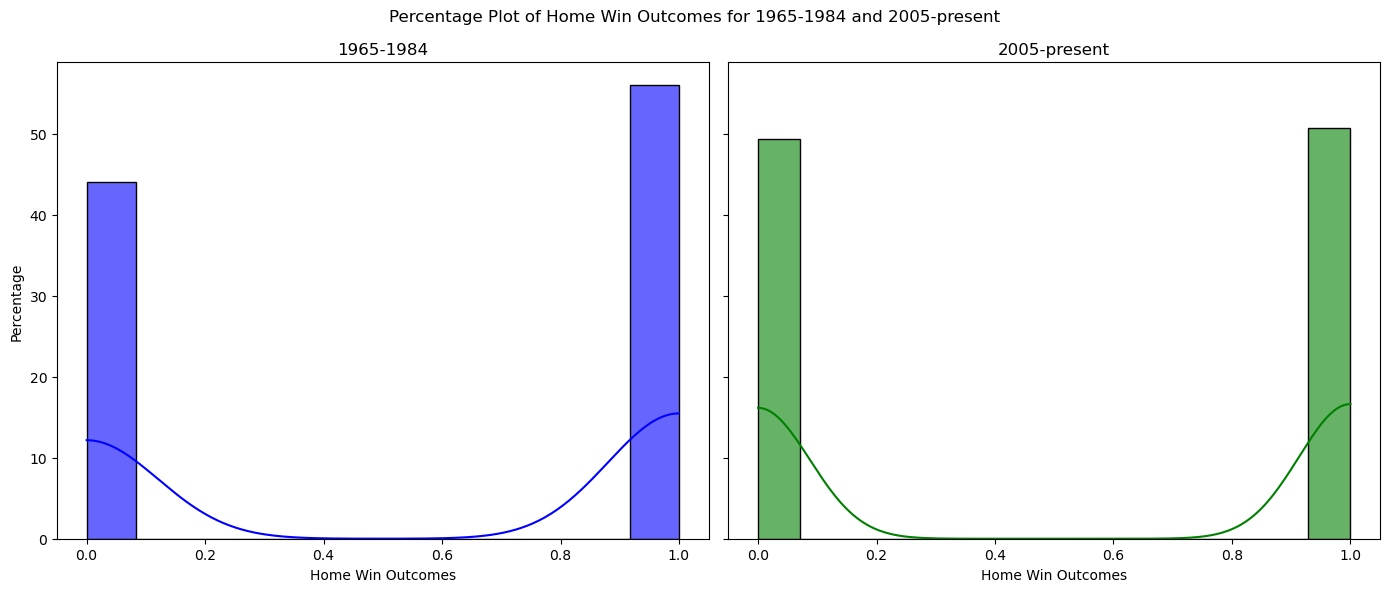

In [48]:
# Assuming you have the outcome data for both periods (already filtered and prepared)
# Replace 'outcome_period2' and 'outcome_period4' with your actual variables

# Create two subplots: one for each period
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Share y-axis for comparison

# Plot the percentage-based histogram for 1965-1984 period
sns.histplot(outcome_period2, kde=True, color='blue', label='1965-1984', ax=axs[0], stat='percent', alpha=0.6)
axs[0].set_title('1965-1984')
axs[0].set_xlabel('Home Win Outcomes')
axs[0].set_ylabel('Percentage')

# Plot the percentage-based histogram for 2005-present period
sns.histplot(outcome_period4, kde=True, color='green', label='2005-present', ax=axs[1], stat='percent', alpha=0.6)
axs[1].set_title('2005-present')
axs[1].set_xlabel('Home Win Outcomes')
axs[1].set_ylabel('Percentage')

# Adjust the layout
plt.suptitle('Percentage Plot of Home Win Outcomes for 1965-1984 and 2005-present')
plt.tight_layout()
plt.show()

Accuracy: 0.4453749524172059
Mean Squared Error: 0.29729254281188505


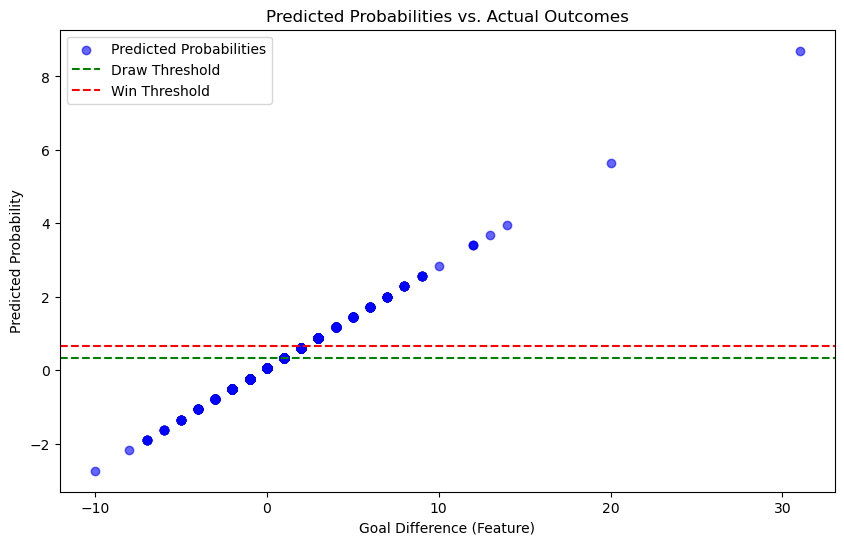

C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


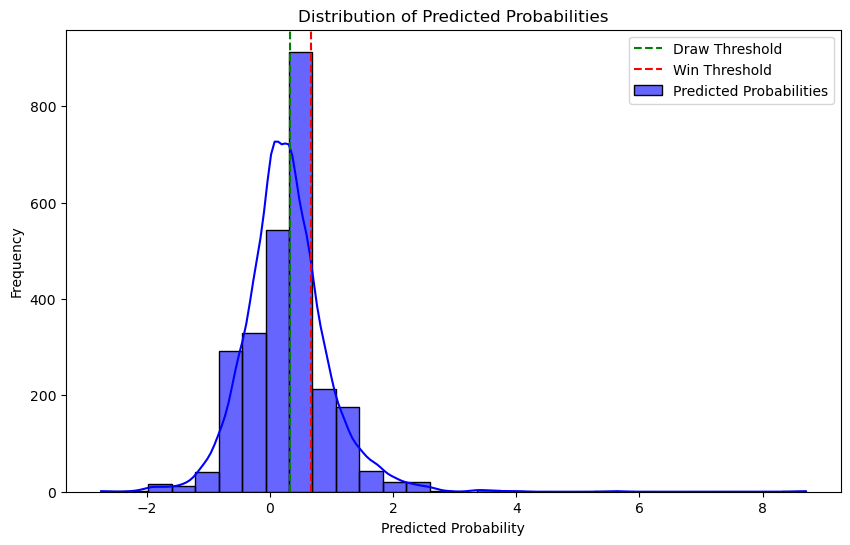

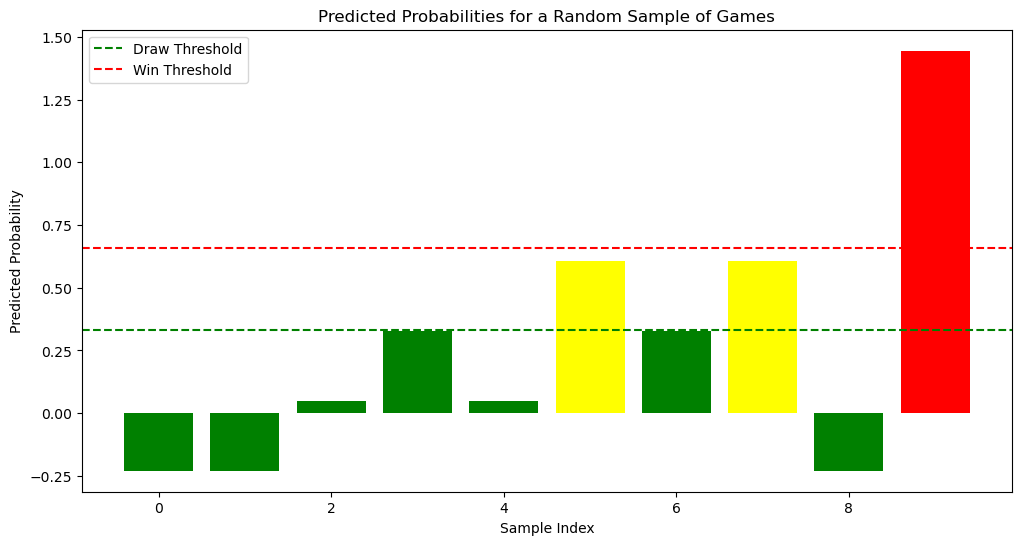

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



# Clean the data (remove rows with NaNs in the 'difference' column)
data_clean = data.dropna(subset=['difference'])

# Create the feature (X) and the target (y)
X = data_clean[['difference']]  # Feature is the 'difference' column
y = np.where(data_clean['difference'] > 0, 1,  # 1 for home win
             np.where(data_clean['difference'] == 0, 0, -1))  # 0 for draw, -1 for home loss

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred_classified)
print(f"Accuracy: {accuracy}")

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


# Map continuous predictions to classes (1 = Win, 0 = Draw, -1 = Loss)
y_pred_classified = np.where(y_pred > 0.66, 1, np.where(y_pred < 0.33, -1, 0))

# Create a scatter plot to visualize predicted probabilities vs actual outcomes
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, color='blue', alpha=0.6, label='Predicted Probabilities')
plt.axhline(y=0.33, color='green', linestyle='--', label='Draw Threshold')
plt.axhline(y=0.66, color='red', linestyle='--', label='Win Threshold')
plt.title('Predicted Probabilities vs. Actual Outcomes')
plt.xlabel('Goal Difference (Feature)')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

# Create a histogram for predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True, color='blue', label='Predicted Probabilities', alpha=0.6)
plt.axvline(x=0.33, color='green', linestyle='--', label='Draw Threshold')
plt.axvline(x=0.66, color='red', linestyle='--', label='Win Threshold')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create a bar plot for predicted probabilities for a sample of games
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(np.arange(len(y_pred)), size=10, replace=False)  # Random sample of 10 games
sample_pred = y_pred[sample_indices]
plt.bar(np.arange(len(sample_pred)), sample_pred, color=['green' if p < 0.33 else 'red' if p > 0.66 else 'yellow' for p in sample_pred])
plt.axhline(y=0.33, color='green', linestyle='--', label='Draw Threshold')
plt.axhline(y=0.66, color='red', linestyle='--', label='Win Threshold')
plt.title('Predicted Probabilities for a Random Sample of Games')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()


Accuracy: 0.7974876284735439
Mean Squared Error: 0.12044686130617478


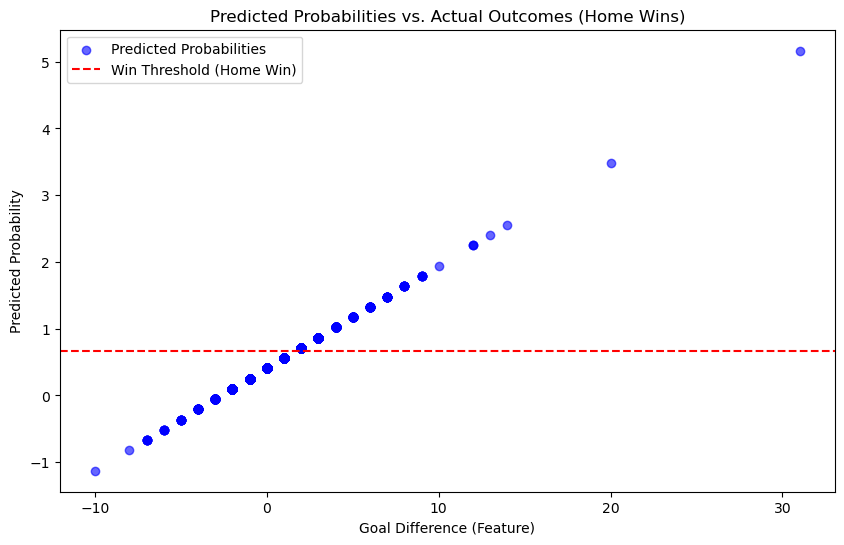

C:\Users\Nikita\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


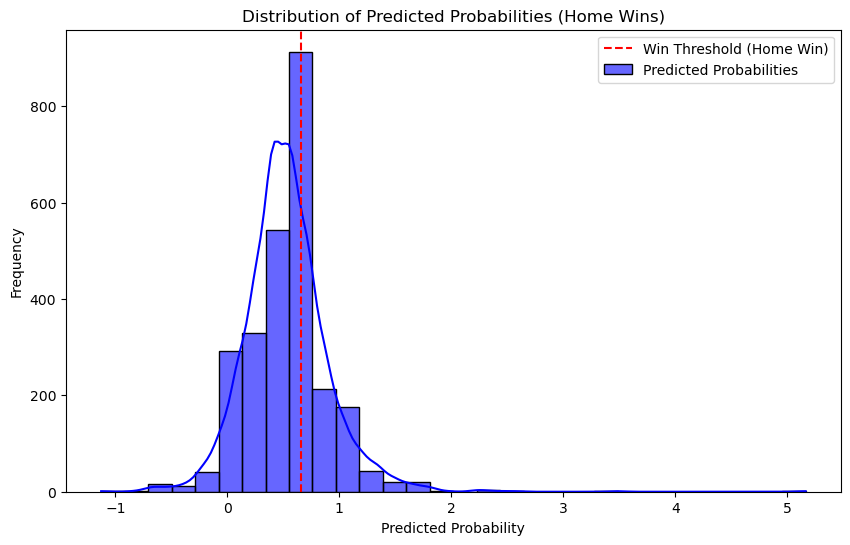

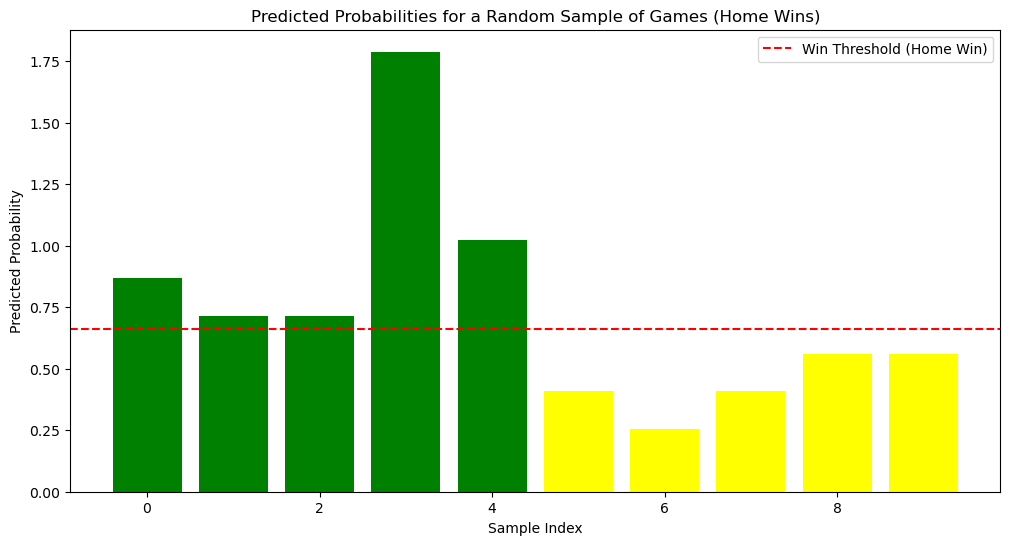

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

# Assuming 'data' is already loaded
# Clean the data (remove rows with NaNs in the 'difference' column)
data_clean = data.dropna(subset=['difference'])

# Create the feature (X) and the target (y)
X = data_clean[['difference']]  # Feature is the 'difference' column
y = np.where(data_clean['difference'] > 0, 1, 0)  # 1 for home win, 0 for non-home win (loss or draw)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Map continuous predictions to classes (1 = Win, 0 = Non-Home Win)
y_pred_classified = np.where(y_pred > 0.66, 1, 0)  # Use 0.66 as the threshold for a home win

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred_classified)
print(f"Accuracy: {accuracy}")

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Create a scatter plot to visualize predicted probabilities vs actual outcomes (focusing on home wins)
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_pred, color='blue', alpha=0.6, label='Predicted Probabilities')
plt.axhline(y=0.66, color='red', linestyle='--', label='Win Threshold (Home Win)')
plt.title('Predicted Probabilities vs. Actual Outcomes (Home Wins)')
plt.xlabel('Goal Difference (Feature)')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

# Create a histogram for predicted probabilities focusing on home wins
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True, color='blue', label='Predicted Probabilities', alpha=0.6)
plt.axvline(x=0.66, color='red', linestyle='--', label='Win Threshold (Home Win)')
plt.title('Distribution of Predicted Probabilities (Home Wins)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create a bar plot for predicted probabilities for a sample of games (focusing on home wins)
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(np.arange(len(y_pred)), size=10, replace=False)  # Random sample of 10 games
sample_pred = y_pred[sample_indices]
plt.bar(np.arange(len(sample_pred)), sample_pred, color=['green' if p > 0.66 else 'yellow' for p in sample_pred])
plt.axhline(y=0.66, color='red', linestyle='--', label='Win Threshold (Home Win)')
plt.title('Predicted Probabilities for a Random Sample of Games (Home Wins)')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()


In [77]:
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error

# Generate random predictions (0 or 1) with the same size as the test set
random_predictions = np.random.choice([0, 1], size=len(y_test))

# Evaluate accuracy of random predictions
random_accuracy = accuracy_score(y_test, random_predictions)
random_mse = mean_squared_error(y_test, random_predictions)

print(f"Random Prediction Accuracy: {random_accuracy}")
print(f"Random Prediction Mean Squared Error: {random_mse}")

# Compare with model's accuracy and MSE
print(f"Model Accuracy: {accuracy}")
print(f"Model Mean Squared Error: {mse}")


Random Prediction Accuracy: 0.49524172059383326
Random Prediction Mean Squared Error: 0.5047582794061667
Model Accuracy: 0.7974876284735439
Model Mean Squared Error: 0.12044686130617478
